<a href="https://colab.research.google.com/github/TejasAdsul/Kaggle_projects/blob/main/Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KAGGLE SETUP

In [ ]:
from google.colab import files
import time

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir /root/.kaggle
time.sleep(3)
!cp /content/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
import kaggle

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip


In [ ]:
!rm -rf /content/chest_xray/chest_xray/

# New Section

In [ ]:
!pip install -U albumentations

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from glob import glob
import shutil
import cv2
import time
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
import copy
import albumentations as A
from albumentations.pytorch import ToTensorV2
plt.ion() 
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
####################### SET EXPERIMENT IMAGE SIZE ##########################
global_image_size = 128

In [ ]:
def resize_and_pad(im, desired_size = global_image_size):
    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = cv2.resize(im, (new_size[1], new_size[0]), interpolation=cv2.INTER_AREA)

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT)
    return new_im

In [ ]:
##########################################################################################
################################# BEWARE DON'T RUN TWICE #################################
##########################################################################################
for i in ['test','train','val']:
  for j in ['NORMAL','PNEUMONIA']:
    imgs = glob(f'/content/chest_xray/{i}/{j}/*.*')
    for img in imgs:
      image = cv2.imread(img)
      image = resize_and_pad(image, global_image_size)
      # if np.random.random() < 0.1 and i=='train':
      #   os.remove(img)
      #   cv2.imwrite(img.replace('train','val'), image)

In [ ]:
def update_data(paths, classe, typ):
  df = pd.DataFrame(columns=['class','path','type'])
  for i in paths:
    df = df.append({'class': classe, 'path':i, 'type':typ}, ignore_index=True)
  return df

In [ ]:
data = pd.DataFrame(columns=['class','path','type'])

for typ in ['test','train','val']:
  normal = glob(f'/content/chest_xray/{typ}/NORMAL/*.*')
  pneumonia = glob(f'/content/chest_xray/{typ}/PNEUMONIA/*.*')
  bacterial = []
  viral = []

  for i in pneumonia:
    if 'bacteria' in i:
      bacterial.append(i)
    else:
      viral.append(i)

  # Split training data in train and validation
  data = data.append(update_data(normal, 'normal',typ))
  data = data.append(update_data(bacterial, 'bacterial',typ))
  data = data.append(update_data(viral, 'viral',typ))

In [ ]:
classes = ['normal','bacterial','viral']
labels2keys = {value: key for (key,value) in enumerate(classes)}
keys2labels = {key:value for (key,value) in enumerate(classes)}

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, typ, data):
    self.lr_transform = A.Compose([
      # A.ShiftScaleRotate(shift_limit=0, scale_limit=0.3,rotate_limit=0,border_mode=0, p=0.5),
      A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
      A.JpegCompression(90, 100, p=0.5),
      # A.RandomResizedCrop(224, 224, scale=(1, 1), ratio=(1, 1),interpolation=3, p=1.0),
      # A.CLAHE(0.3),
      A.RandomGamma(p=0.3),
      A.MedianBlur(blur_limit=3, p=0.3),
      # A.RandomSunFlare(flare_roi=(0, 0.5, 1, 1),p=0.3, num_flare_circles_lower=0, num_flare_circles_upper=1,src_radius=70),
      # A.RandomFog(p=0.9,alpha_coef=0.2)
    ])
    self.norm_transform = A.Compose([
  #             A.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
      A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
      ToTensorV2(),
    ])
    self.data = data[data['type']==typ]

  def __getitem__(self, index):
    imglr = cv2.imread(self.data['path'].iloc[index])
    imglr = cv2.cvtColor(imglr, cv2.COLOR_BGR2RGB)
    img_lr = self.lr_transform(image=imglr)['image']
    # img_lr = resize_and_pad(img_lr, 128)
    img_lr = self.norm_transform(image=img_lr)['image']
    
    label = self.data['class'].iloc[index]
    return img_lr, labels2keys[label]
  
  def __len__(self):
    return len(self.data)

In [ ]:
train_dataset = ImageDataset('train',data)
val_dataset = ImageDataset('val', data)
test_dataset = ImageDataset('val', data)

# In case of weird erros after running this, try to set num_workers to 0
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=0)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:870: FutureWarning: This class has been deprecated. Please use ImageCompression
  FutureWarning,


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


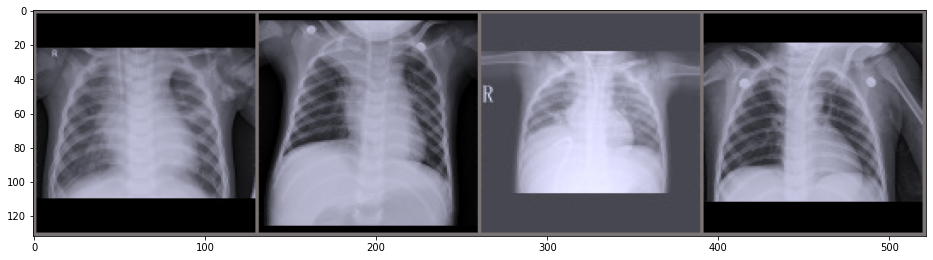

bacterial bacterial bacterial bacterial


In [ ]:
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)

dataiter = iter(train_loader)
images, labels = dataiter.next()
inv_tensor = inv_normalize(torchvision.utils.make_grid(images[:4]))
plt.figure(figsize=(16,9))
imshow(inv_tensor)
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
dataset_sizes = {'train':len(data[data['type']=='train']),'val':len(data[data['type']=='val']), 'test':len(data[data['type']=='test'])}
dataset_sizes

{'test': 624, 'train': 4706, 'val': 526}

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 100):
  since = time.time()
  # Take backup of pretrained weights
  best_model_wts = copy.deepcopy(model.state_dict())
  best_accuracy = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
        loader = train_loader
      else:
        model.eval()   # Set model to evaluate mode
        loader = val_loader

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_accuracy:
        best_accuracy = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

  time_elapsed = time.time() - since
  print('\nTraining complete in {:.0f}m {:.0f}s'.format(
  time_elapsed // 60, time_elapsed % 60))
  print('\nBest val Acc: {:4f}'.format(best_accuracy))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [ ]:
def visualize_model(model, loader, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}, actual: {}'.format(classes[preds[j]], classes[labels[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
            model.train(mode=was_training)
            return
    model.train(mode=was_training)

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(512,1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128,3)
)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.75)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


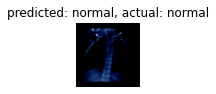

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


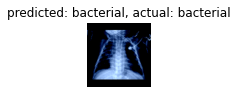

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


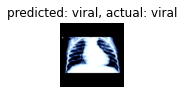

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


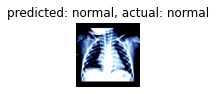

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


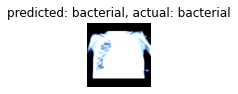

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


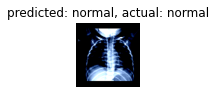

In [ ]:

visualize_model(model, test_loader)

In [ ]:
y_pred_list = []
y_true_list = []
labels = {}

with torch.no_grad():
    model.eval()
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        y_test_pred = torch.softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

from sklearn.metrics import classification_report
y_pred = []
y_true = []
for i in y_pred_list: y_pred.extend(i)
for i in y_true_list: y_true.extend(i)
pd.DataFrame(classification_report(y_true, y_pred,target_names=classes,output_dict=True))

,normal,bacterial,viral,accuracy,macro avg,weighted avg
precision,0.929078,0.820833,0.579310,0.78327,0.776407,0.789493
recall,0.935714,0.772549,0.641221,0.78327,0.783162,0.783270
f1-score,0.932384,0.795960,0.608696,0.78327,0.779013,0.785632
support,140.000000,255.000000,131.000000,0.78327,526.000000,526.000000
